In [1]:
import pandas as pd
import os
from arch.unitroot import PhillipsPerron
from statsmodels.tsa.vector_ar.vecm import VAR
from statsmodels.tsa.stattools import adfuller, coint, pacf
from utils import Utils as Ut
from dotenv import load_dotenv
load_dotenv()
path_to_data = os.getenv("PATH_TO_DATA")

In [2]:
ticker1 = "AZN"
ticker2 = "PFE"
pair_paths = Ut.get_data(ticker1, ticker2, path_to_data)


with open(rf"{pair_paths[ticker1]}", "r") as s1:
    with open(rf"{pair_paths[ticker2]}", "r") as s2:
        unclean_price_series1 = pd.read_csv(s1)
        print(ticker1 + "\n", unclean_price_series1)

        unclean_price_series2 = pd.read_csv(s2)
        print(ticker2 + "\n", unclean_price_series2)

AZN
       Unnamed: 0    datetime   open   high    low  close   volume
0              0  2023-04-19  74.55  74.90  74.41  74.84  4487800
1              1  2023-04-18  75.36  75.83  74.47  75.02  7565700
2              2  2023-04-17  73.76  73.82  73.01  73.63  4408700
3              3  2023-04-14  74.33  74.47  73.57  73.86  3981100
4              4  2023-04-13  74.05  74.83  74.02  74.77  3794200
...          ...         ...    ...    ...    ...    ...      ...
4740        4740  2004-06-21  23.75  23.80  23.63  23.63   841400
4741        4741  2004-06-18  23.79  23.94  23.77  23.77  1615200
4742        4742  2004-06-17  23.64  23.70  23.52  23.68  1135600
4743        4743  2004-06-16  23.75  23.82  23.63  23.77  1060400
4744        4744  2004-06-15  23.43  23.57  23.39  23.48  1637400

[4745 rows x 7 columns]
PFE
       Unnamed: 0    datetime   open   high    low  close    volume
0              0  2023-04-19  40.43  40.56  40.20  40.24  17207800
1              1  2023-04-18  41.28  41

In [3]:
start_time = "2004-06-16"
end_time = "2010-06-16"
forecast_days = 15

2023-09-01 09:28:57 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


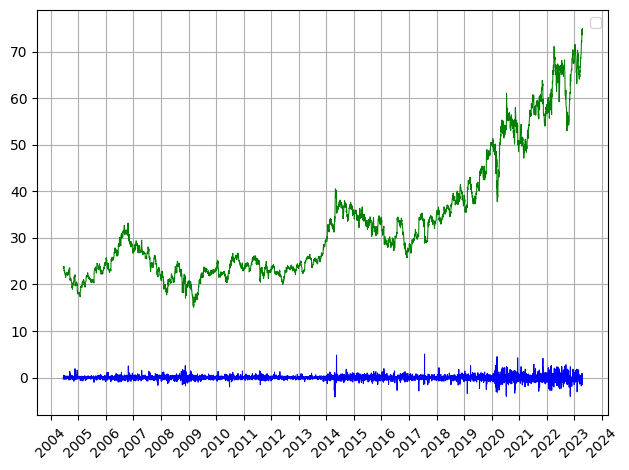

2023-09-01 09:28:58 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


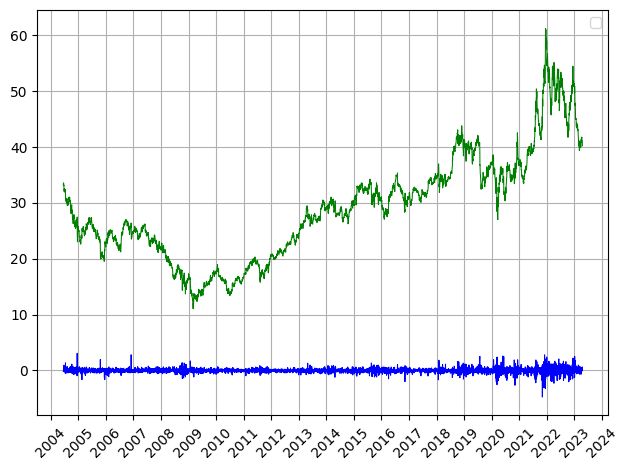

In [4]:


price_series1_whole_nodiff = Ut.clean_df_nodiff(unclean_price_series1)
price_series1_whole = Ut.clean_df(unclean_price_series1)
price_series2_whole_nodiff = Ut.clean_df_nodiff(unclean_price_series2)
price_series2_whole = Ut.clean_df(unclean_price_series2)

Ut.plot_df(price_series1_whole, price_series1_whole_nodiff, merge_and_plot=True)
Ut.plot_df(price_series2_whole, price_series2_whole_nodiff, merge_and_plot=True)

In [5]:
def create_training_set(price_series, start_time, end_time):
    new_price_series = price_series
    new_price_series = new_price_series.truncate(start_time, end_time)
    return new_price_series

price_series1 = create_training_set(price_series1_whole, start_time, end_time)
price_series2 = create_training_set(price_series2_whole, start_time, end_time)
print(ticker1 + "\n", price_series1)
print(ticker2 + "\n", price_series2)



AZN
 datetime
2010-06-16    0.00
2010-06-15    0.09
2010-06-14   -0.46
2010-06-11   -0.01
2010-06-10   -0.42
              ... 
2004-06-22   -0.31
2004-06-21    0.08
2004-06-18    0.14
2004-06-17   -0.09
2004-06-16    0.09
Name: close, Length: 1512, dtype: float64
PFE
 datetime
2010-06-16    0.01
2010-06-15    0.04
2010-06-14   -0.18
2010-06-11    0.13
2010-06-10   -0.53
              ... 
2004-06-22   -0.06
2004-06-21    0.29
2004-06-18    0.22
2004-06-17   -0.16
2004-06-16   -0.04
Name: close, Length: 1512, dtype: float64


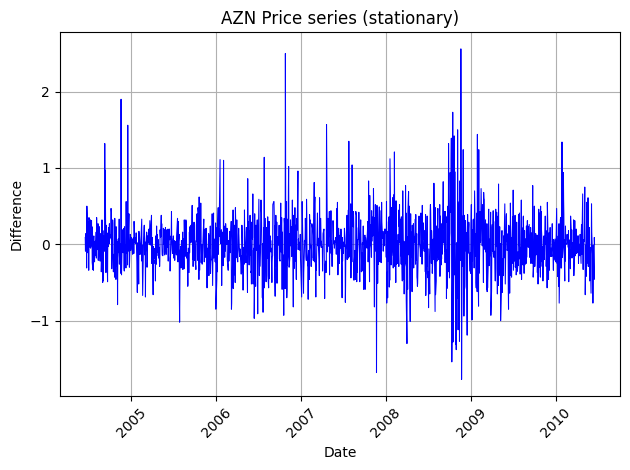

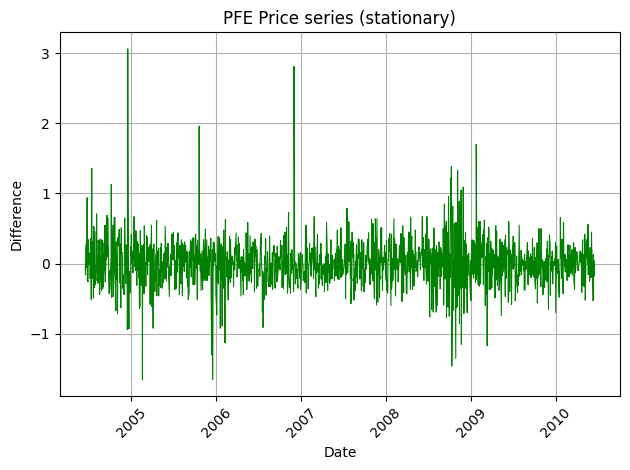

In [6]:

Ut.plot_df(price_series1, title=f"{ticker1} Price series (stationary)", xlabel="Date", ylabel="Difference", color="blue")
Ut.plot_df(price_series2, title=f"{ticker2} Price series (stationary)", xlabel="Date", ylabel="Difference", color="green")

In [7]:
pp1 = PhillipsPerron(price_series1, trend='n')
print(ticker1 + "...\n", str(pp1.summary()), "\n")

pp2 = PhillipsPerron(price_series2, trend='n')
print(ticker2 + "...\n", str(pp2.summary()))

AZN...
      Phillips-Perron Test (Z-tau)    
Test Statistic                -39.594
P-value                         0.000
Lags                               24
-------------------------------------

Trend: No Trend
Critical Values: -2.57 (1%), -1.94 (5%), -1.62 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary. 

PFE...
      Phillips-Perron Test (Z-tau)    
Test Statistic                -39.051
P-value                         0.000
Lags                               24
-------------------------------------

Trend: No Trend
Critical Values: -2.57 (1%), -1.94 (5%), -1.62 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [8]:
result = adfuller(price_series1)
result2 = adfuller(price_series2)

print("p val", result[1])
print("p val", result2[1])

p val 1.6410552858534234e-21
p val 2.0682275928364335e-10


In [9]:
window_size = 35
cointegration_results = []
for i in range(len(price_series1) - window_size + 1):
    window_price_series1 = price_series1[i:i+window_size]
    window_price_series2 = price_series2[i:i+window_size]
    score, p_value, _ = coint(window_price_series1, window_price_series2)
    cointegration_results.append(p_value < 0.05)

num_cointegrated = sum(cointegration_results)
coint_ratio = num_cointegrated/len(cointegration_results)

print(f"Cointegration ratio for rolling window {window_size}: {round(coint_ratio, 2)}")

Cointegration ratio for rolling window 35: 0.82


In [28]:


lags = 40

merged_series = pd.DataFrame()
merged_series.index = price_series1.index
merged_series['price1'] = price_series1
merged_series['price2'] = price_series2

result = Ut.pearson_corr_lags(merged_series, lags)
print(result)

# result1 = Ut.plot_and_extract_pacf(price_series1, title="PACF", lags=lags)
# result2 = Ut.plot_and_extract_pacf(price_series2, title="PACF", lags=lags)

# pacf_values, conf_intervals = pacf(price_series1, nlags=lags, alpha=0.5)

# result = []
# for lag, (pacf_val, (lower_bound, upper_bound)) in enumerate(zip(pacf_values[0:], conf_intervals[0:]), start=1):
#     # Check if the PACF value is outside the confidence interval bounds
#     if pacf_val < lower_bound or pacf_val > upper_bound:
#         result.append((lag, pacf_val))

# significant_lags = Ut.find_pacf_significant_lags(pacf_values, conf_intervals, threshold=0.1)
# print(significant_lags)





{'10': 0.0020286212852025556, '14': 0.004927399555517377, '20': 6.567728192521228e-05}


For price_series1, lag orders 1,9,14,15

For price_series2, lag orders 1,2,15

We'll first look at AR models.

In [27]:
ar_orders1 = [5, 10, 14]
ar_orders2 = [2, 7, 10, 14, 15, 16, 20, 22]

merged_series = pd.DataFrame()
merged_series.index = price_series1.index
merged_series['price1'] = price_series1
merged_series['price2'] = price_series2

model = VAR(merged_series)
model_fit = model.fit(maxlags=20)
selected_lag_order = model_fit.k_ar
print(selected_lag_order)


50


f:\Coding\Projects\StatArb\Pairstrading\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
f:\Coding\Projects\StatArb\Pairstrading\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [12]:
p_values = model_fit.pvalues
for lag, val in p_values['price1'].items():
    if val <= 0.05:
        print(f"{lag}: p-value = {round(val, 3)}")
print("-----------------")
for lag, val in p_values['price2'].items():
    if val <= 0.05:
        print(f"{lag}: p-value = {round(val, 3)}")

L1.price2: p-value = 0.048
L2.price2: p-value = 0.044
L7.price1: p-value = 0.014
L14.price1: p-value = 0.004
L20.price2: p-value = 0.003
-----------------
L2.price2: p-value = 0.0
L7.price1: p-value = 0.011
L7.price2: p-value = 0.001
L12.price1: p-value = 0.033
L15.price2: p-value = 0.024
L16.price2: p-value = 0.011
L18.price1: p-value = 0.01
L20.price2: p-value = 0.014


2, 14,15,16,18,20

In [13]:

merged_series = Ut.create_merged_series(price_series1, price_series2, ticker1, ticker2)
lag_order = selected_lag_order
forecast = Ut.forecasted(lag_order, merged_series, forecast_days)


f:\Coding\Projects\StatArb\Pairstrading\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
f:\Coding\Projects\StatArb\Pairstrading\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [14]:
def reveal_actual(whole_price_series, forecast_start_time, forecast_end_time):
    actual_series = whole_price_series.truncate(forecast_start_time, forecast_end_time)
    return actual_series

forecasted_period = Ut.get_forecast_dates(forecast_days, end_time)
print(forecasted_period)
actual1 = reveal_actual(price_series1_whole, forecasted_period['start'], forecasted_period['end'])
actual2 = reveal_actual(price_series2_whole, forecasted_period['start'], forecasted_period['end'])

{'start': '2010-06-17', 'end': '2010-07-08', 'num_biz_days': 15}


In [15]:
actual = Ut.create_merged_series(actual1, actual2, ticker1, ticker2)
print("Actual...")
print(actual)
print("\nForecast...")
print(forecast)



Actual...
             AZN   PFE
datetime              
2010-07-08 -0.11  0.05
2010-07-07 -0.23 -0.19
2010-07-06 -0.27 -0.31
2010-07-02 -0.37 -0.15
2010-07-01  0.25  0.09
2010-06-30 -0.20  0.03
2010-06-29  0.80  0.02
2010-06-28 -2.01  0.24
2010-06-25  0.09  0.10
2010-06-24  0.09 -0.17
2010-06-23 -0.09  0.40
2010-06-22  0.00  0.08
2010-06-21 -0.02  0.12
2010-06-18  0.32  0.11
2010-06-17  0.14  0.24

Forecast...
                 AZN       PFE
2010-07-08 -0.036038  0.009228
2010-07-07 -0.014926 -0.016093
2010-07-06  0.161984  0.144575
2010-07-05 -0.050217  0.009289
2010-07-02 -0.047385 -0.038138
2010-07-01  0.000809  0.043628
2010-06-30  0.084791  0.066490
2010-06-29 -0.137327 -0.079897
2010-06-28 -0.099058 -0.047543
2010-06-25  0.109560  0.113467
2010-06-24 -0.076567 -0.009514
2010-06-23 -0.024981 -0.084162
2010-06-22  0.074621  0.100393
2010-06-21 -0.124914 -0.064890
2010-06-18  0.056437  0.008542
2010-06-17  0.054613  0.016278
